In [1]:
from skimage import io, img_as_float, img_as_ubyte
from skimage.metrics import structural_similarity as ssim
from scipy import signal
from math import log10
import matplotlib.pyplot as plt
import numpy as np
import json

In [2]:
def MED(actual, predicted):
    errors = np.abs(actual - predicted)
    return np.median(errors)

def NMED(actual, predicted):
    errors = np.abs(actual - predicted)
    return np.median(errors) / (np.max(actual) - np.min(actual))

def MRED(actual, predicted):

    abs_error = np.abs(predicted - actual)
    # Calculate the relative error
    rel_error = abs_error / actual
    
    # Calculate the mean relative error
    mean_rel_error = np.mean(rel_error)
    
    return mean_rel_error
    # errors = np.abs(actual - predicted)
    # return np.mean(errors / actual)

d:\Master\Emerging_Computing\epcExercise\.venv\lib\site-packages\skimage\metrics\_structural_similarity.py:251: RuntimeWarning: invalid value encountered in divide
  S = (A1 * A2) / D
C:\Users\flori\AppData\Local\Temp\ipykernel_1952\4034730676.py:59: RuntimeWarning: divide by zero encountered in scalar divide
  loadedDict[approxAlgo]["psnr"][indexBit] = round(10 * log10((pic_list[0].max()**2) /mse),2)
C:\Users\flori\AppData\Local\Temp\ipykernel_1952\3573020273.py:13: RuntimeWarning: invalid value encountered in divide
  rel_error = abs_error / actual
d:\Master\Emerging_Computing\epcExercise\.venv\lib\site-packages\skimage\metrics\_structural_similarity.py:251: RuntimeWarning: invalid value encountered in divide
  S = (A1 * A2) / D
C:\Users\flori\AppData\Local\Temp\ipykernel_1952\4034730676.py:59: RuntimeWarning: divide by zero encountered in scalar divide
  loadedDict[approxAlgo]["psnr"][indexBit] = round(10 * log10((pic_list[0].max()**2) /mse),2)
C:\Users\flori\AppData\Local\Temp\ipyk

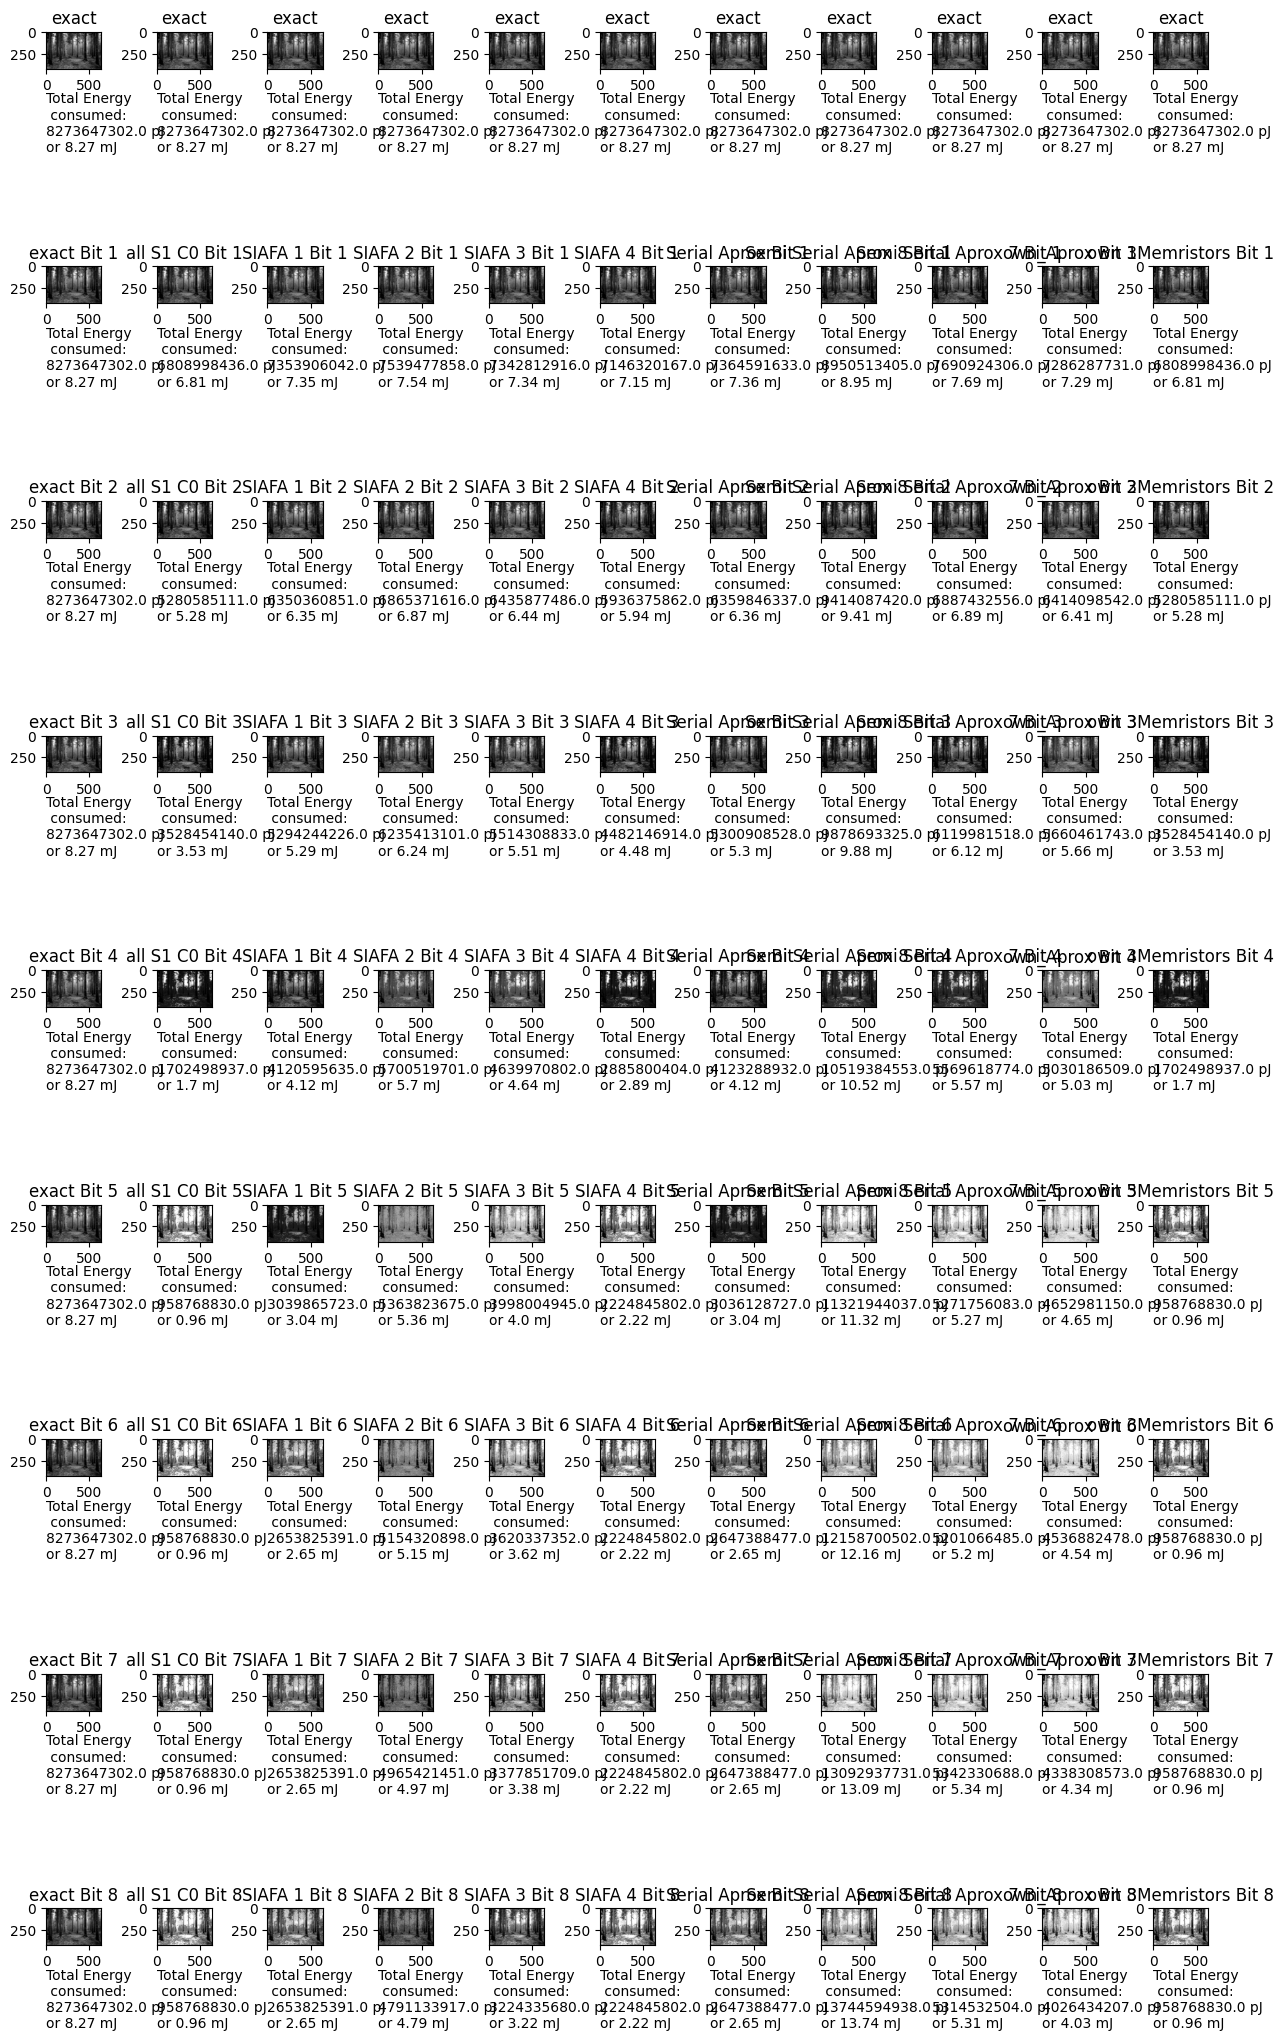

In [30]:
# algo_list = ["own_Aprox","SIAFA 1","SIAFA 2","SIAFA 3","SIAFA 4","Serial Aprox","Semi Serial Aprox 7"]
algo_list = ["exact","all S1 C0","SIAFA 1","SIAFA 2","SIAFA 3","SIAFA 4","Serial Aprox","Semi Serial Aprox 8", "Semi Serial Aprox 7","own_Aprox","own 3Memristors"]

parsed_data = {}
rows = 9
coll = len(algo_list)
bit_list = range(0,rows)

empty_list = [0]*rows

kernelname_list = []
kernelname_list.append("blurring")
kernelname_list.append("edge_Detection")

for i, name in enumerate(algo_list):
    parsed_data[name] = {"ssi": empty_list, "psnr": empty_list, "energy_con": empty_list, "med": empty_list, "nmed": empty_list, "mred": empty_list}

# load data from jsonfile 
with open('data.json', 'w') as json_file:
    json.dump(parsed_data, json_file, indent=4)

# Load the data from the JSON file into a dictionary
with open('data.json', 'r') as json_file:
    loadedDict = json.load(json_file)


fig, axs = plt.subplots(rows, coll, figsize=(15, 5))  # 5 rows, 1 column
plt.subplots_adjust(left=0.125, bottom=6, right=0.9, top=10, wspace=1, hspace=0.9)

#blurring
# loop throw all Bitpositions 
for indexAlgo, approxAlgo in enumerate(algo_list):
    pic_list = []
    energy_list = []
    # loop throw all Algorithm
    for indexBit, approxBit in enumerate(bit_list):
        # show picture in subplot

        with open(f'data_blurring/{approxAlgo}_{indexBit}.json', 'r') as json_file:
            energy_list.append(json.load(json_file))
        
        pic_list.append(np.load(f"data_blurring/outputimage_{approxAlgo}_{indexBit}.npy"))

        # print(pic_list[0])
        
        axs[indexBit,indexAlgo].imshow(pic_list[-1], cmap = "gray")
        # Add an annotation to the subplot
        axs[indexBit,indexAlgo].annotate(f"\nTotal Energy\n consumed: \n{round(energy_list[indexBit],0)} pJ \nor {round(energy_list[indexBit]/10**9,2)} mJ", (0,0), (0,-5),xycoords='axes fraction', textcoords='offset points', va='top')
    
        if indexBit == 0:
            axs[indexBit,indexAlgo].set_title(f"exact")
        else:
            axs[indexBit,indexAlgo].set_title(f"{approxAlgo} Bit {approxBit}")
        try:
            data_range = pic_list[0].max() - pic_list[-1].max()  
            mse = np.mean((pic_list[0] - pic_list[-1])**2)     
            # load results to dictionary
            loadedDict[approxAlgo]["ssi"][indexBit] = round(ssim(pic_list[0], pic_list[-1], data_range=data_range),2)
            loadedDict[approxAlgo]["psnr"][indexBit] = round(10 * log10((pic_list[0].max()**2) /mse),2)
            loadedDict[approxAlgo]["energy_con"][indexBit] = round(energy_list[-1]/10**3,2)
            loadedDict[approxAlgo]["med"][indexBit] = MED(pic_list[0], pic_list[-1])
            loadedDict[approxAlgo]["nmed"][indexBit] = NMED(pic_list[0], pic_list[-1])
            loadedDict[approxAlgo]["mred"][indexBit] = MRED(pic_list[0], pic_list[-1])
            
        except Exception as e:
            print(f'Error plot at: indexBit {indexBit} {e}')
        else:
            continue
# Show the plot
plt.show()


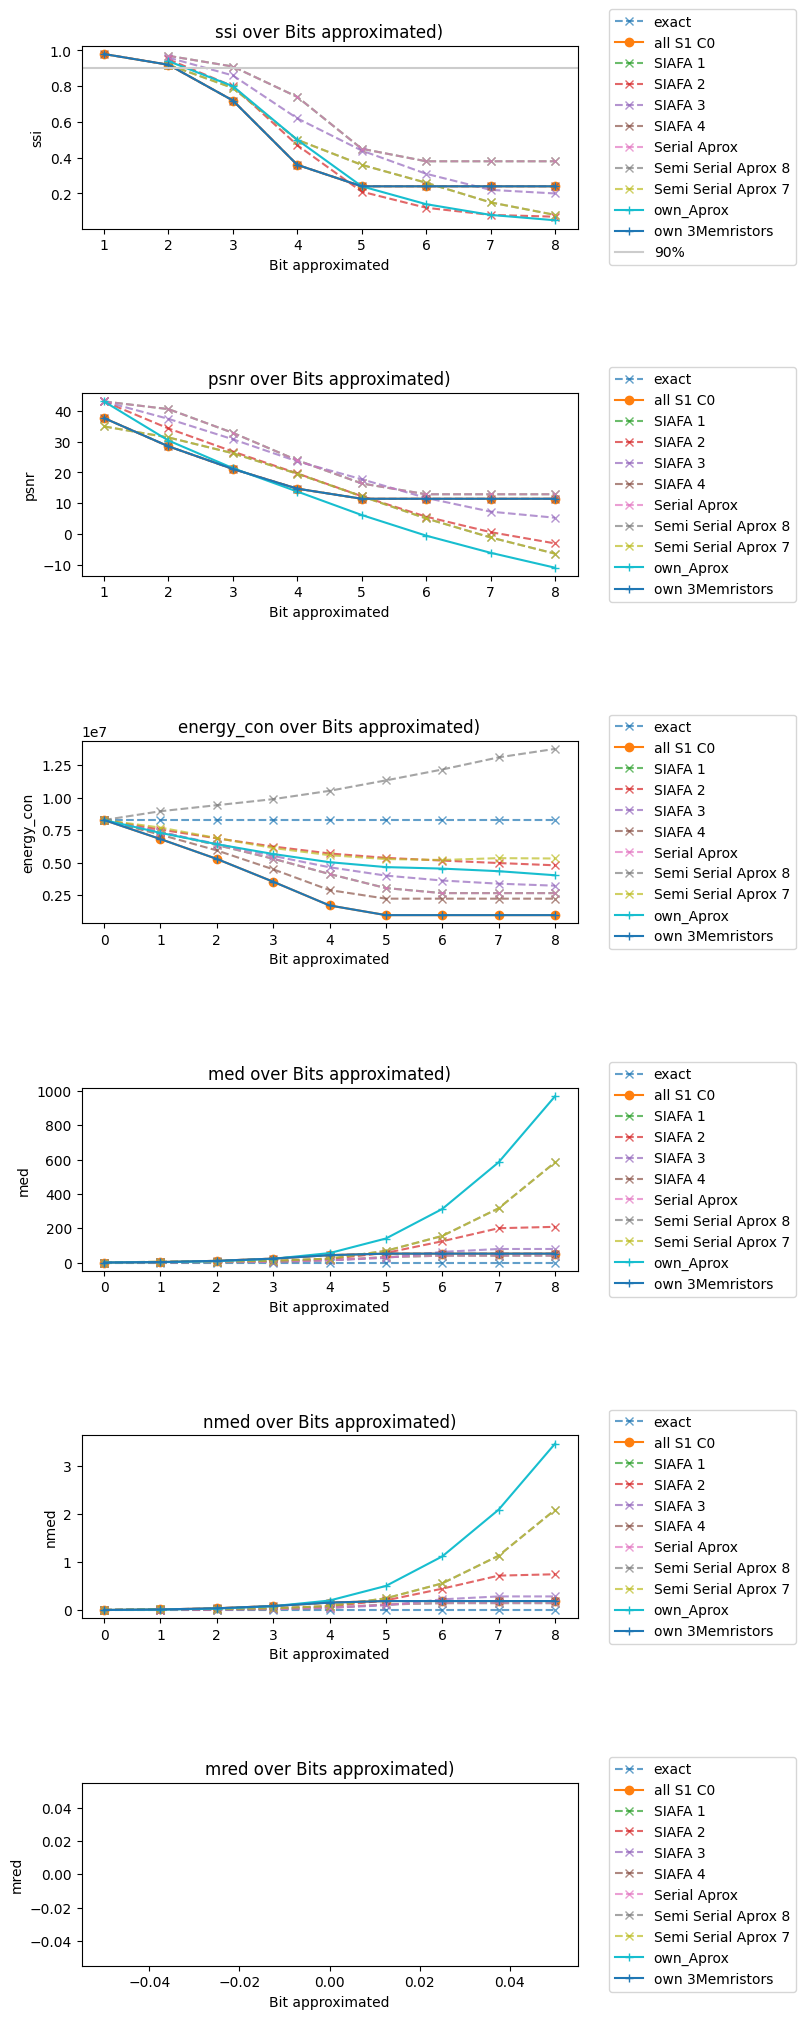

In [28]:
#error metrics list 
metrics_list = ["ssi", "psnr", "energy_con", "med", "nmed", "mred"]
rows = len(metrics_list)
coll = 1

fig, axs = plt.subplots(rows, coll )
plt.subplots_adjust(left=0.125, bottom=6, right=0.9, top=10, wspace=1, hspace=0.9)

#blurring
# loop throw all Bitpositions 
for indexMetric, metric in enumerate(metrics_list):

    for indexalgo, algo in enumerate(algo_list):
        if 'own' in algo:
            axs[indexMetric].plot(loadedDict[algo][metric], "+-", label=algo)
        elif 'all' in algo:
            axs[indexMetric].plot(loadedDict[algo][metric], "o-", label=algo)
        else:
            axs[indexMetric].plot(loadedDict[algo][metric], "x--", label=algo, alpha=0.7)

    if "ssi" in metric:
        axs[indexMetric].axhline(y=0.9, color='0.8', linestyle='-', label='90%')
    axs[indexMetric].set_title(f"{metric} over Bits approximated)")
    axs[indexMetric].set_xlabel("Bit approximated")
    axs[indexMetric].set_ylabel(f'{metric}')
    # axs[indexMetric].legend()
    axs[indexMetric].legend(bbox_to_anchor=(1.05, 0.5), loc='center left')

# plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

[]

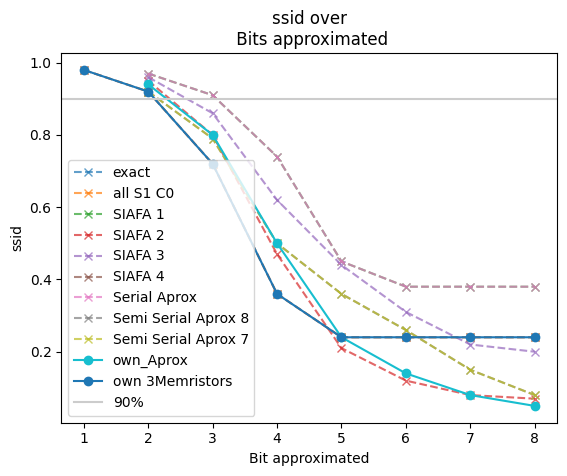

In [26]:
# plot ssid over approximation of different amount of Bits and algorithms
for indexalgo, algo in enumerate(algo_list):
    if 'own' in algo:
        plt.plot(loadedDict[algo]["ssi"],"o-", label=algo)
    else:
        plt.plot(loadedDict[algo]["ssi"],"x--", label=algo, alpha=0.7)
    plt.title(f"ssid over\n Bits approximated")
    plt.xlabel("Bit approximated")
    plt.ylabel("ssid")

plt.axhline(y=0.9, color='0.8', linestyle='-', label='90%')
plt.legend()
plt.plot()

[]

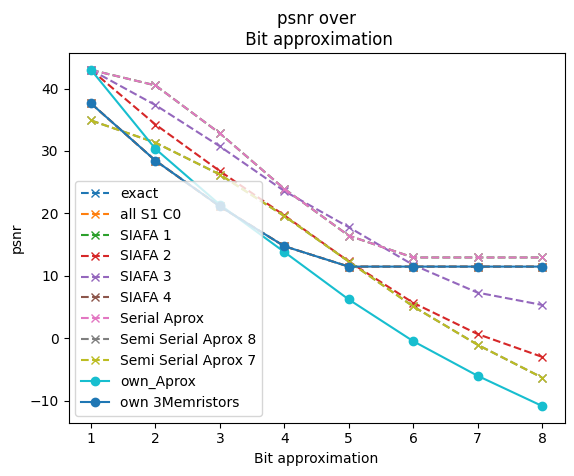

In [6]:
# peak signal to noice ratio over different amount of Bits and algorithms
for indexalgo, algo in enumerate(algo_list):
    if 'own' in algo:
        plt.plot(loadedDict[algo]["psnr"],"o-",  label=algo)
    else:
        plt.plot(loadedDict[algo]["psnr"],"x--",  label=algo)
    plt.title(f"psnr over\n Bit approximation")
    plt.xlabel("Bit approximation")
    plt.ylabel("psnr")


plt.legend()
plt.plot()

[]

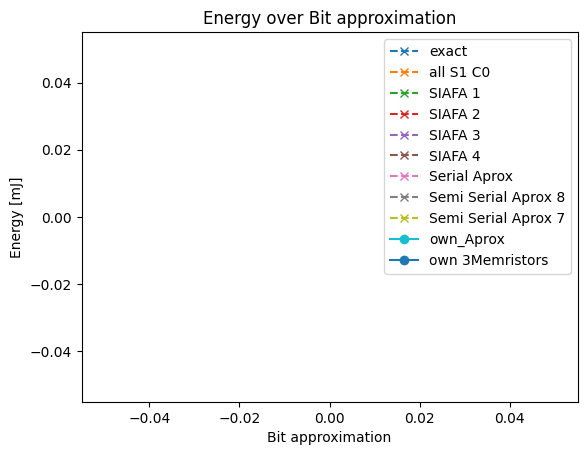

In [7]:
# energy consumption over different amount of Bits and algorithms
for indexalgo, algo in enumerate(algo_list):
    if 'own' in algo:
        plt.plot(loadedDict[algo]["mred"],"o-",  label=algo)
    else:
        plt.plot(loadedDict[algo]["mred"],"x--",  label=algo)
    plt.title(f"Energy over Bit approximation")
    plt.xlabel("Bit approximation")
    plt.ylabel("Energy [mJ]")

plt.legend()
plt.plot()